# User-User Collaborative Filtering From Scratch
Here you will implement User-User Collaborative Filtering from scratch i.e. by only using numpy and scipy libraries. We will use the MovieLens 20M dataset.

**PREREQUISITE:** Download the MovieLens 20M dataset from <http://files.grouplens.org/datasets/movielens/ml-20m.zip>. Extract the contents of the zip file as a folder named `data` located in the same folder as this notebook. You should have a file `ml-20m/ratings.csv`, which is what we'll be working with. 

**TASK:** Your job is to understand the notebook and also *fill in the missing code*. The place to enter your code is clearly marked with comments (try to do these parts, you will learn a lot!).

**Note:** Wehenevr we set the `DEBUG` variable to True, it means that we are going to use a subsample of the ratings. This is only in order to reduce the execution time of our code.

In [96]:
# downloading the data
!pip install wget
!mkdir data
import wget
filename = wget.download("http://files.grouplens.org/datasets/movielens/ml-20m.zip", out="data/ml-20m.zip")

mkdir: cannot create directory ‘data’: File exists


In [97]:
# unzip the zip file to get the data-sets
!unzip data/ml-20m.zip

## Preparation

### Import modules
Import python modules we will be using. 

In [1]:
import csv
import pandas as pd
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import norm
import sklearn.preprocessing as pp

Set some formatting options.

In [2]:
np.set_printoptions(threshold=500, precision=4)
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 20

### Read the data
Load data from csv file located in `ml-100k/u.data`. The result is stored in a `pandas.DataFrame` called `ratings_raw`.

In [3]:
ratings_raw = pd.read_csv('ml-20m/ratings.csv')
movies = pd.read_csv('ml-20m/movies.csv')
links = pd.read_csv('ml-20m/links.csv')

Let's see what the data look like.

In [4]:
display(ratings_raw.head())
display(movies.head())
display(links.head())
print("Distinct users:", len(ratings_raw.userId.unique()))
print("Distinct items:", len(ratings_raw.movieId.unique()))

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Distinct users: 138493
Distinct items: 26744


Lets visualize some of the movie data. We will use [tmdbsimple](https://pypi.org/project/tmdbsimple/) which is a wrapper, written in Python, for The Movie Database (TMDb) API v3.

In [9]:
# you may already have this package as we used it in week 2
!pip install tmdbsimple

In [23]:
from tmdb_class import TMDB # we have provided a python class called tmdb_class.py to retrieve the url of poster images
from IPython.display import Image
from IPython.display import display, HTML

# which movies did user watch?
def make_html(image_url):
     return '<img src="{}" style="display:inline;margin:1px" width="100" height="100"/>'\
            .format(image_url)
        
def show_movies_for_user(userId, verbose=False, show_all=False):
    """Retrieve posters of top rated movies for userId.
    
    Note: this accepts the original user id
    """
    html = ''
    max_movies = 10
    i=0
    
    user_movies = ratings_raw[ratings_raw.userId == userId]["movieId"]
    print("User ", userId , " watched ", len(user_movies), ' movies') 
    
    user_movies = ratings_raw[ratings_raw.userId == userId].sort_values("rating", ascending=False) 
    for index, row in user_movies.iterrows():
        movieId = row["movieId"]
        movie_item = links[links.movieId == movieId]
        tmdbId = movie_item["tmdbId"].item()
        if verbose:
            print(movieId, tmdbId)
        if np.isnan(tmdbId):
            url = None
        else:
            url = TMDB().get_poster_path_by_id(int(tmdbId))
        html = html + make_html(url)
        i +=1
        
        if ~show_all and (i == max_movies):
                break
        
    display(HTML(html))

In [25]:
# let's see which movies user 5 watches
show_movies_for_user(5, verbose=True) 

User  5  watched  66  movies
1362    9390.0
Name: tmdbId, dtype: float64
1393.0 9390.0


/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


708   NaN
Name: tmdbId, dtype: float64
720.0 nan
373    1637.0
Name: tmdbId, dtype: float64
377.0 1637.0
376    36955.0
Name: tmdbId, dtype: float64
380.0 36955.0
436    11566.0
Name: tmdbId, dtype: float64
440.0 11566.0
450    37233.0
Name: tmdbId, dtype: float64
454.0 37233.0
453    5503.0
Name: tmdbId, dtype: float64
457.0 5503.0
767    602.0
Name: tmdbId, dtype: float64
780.0 602.0
724    664.0
Name: tmdbId, dtype: float64
736.0 664.0
496    788.0
Name: tmdbId, dtype: float64
500.0 788.0


In [28]:
# some helper functions
def get_name_for_movie_id(movie_id):
    """Returns the name of a movie_id (based on ratings_raw)"""
    
    try: 
        movie_name = movies[movies.movieId == movie_id]["title"].item()
    except KeyError:
        movie_name = None
    return movie_name
    
    
def show_genres_histogram_for_user(user_id):
    """Create histogram of movies genres user_id has watched.
    
    Note: this uses the original user_id NOT the userIDX
    """
    
    user_movies = ratings_raw[ratings_raw.userId == user_id]["movieId"]
    print("User ", user_id , " watched ", len(user_movies), ' movies') 
    user_movies_with_genre = movies[movies.movieId.isin(user_movies)]
    display(user_movies_with_genre)
    
    genres_list = []
    for index, row in user_movies_with_genre.iterrows():
        genres_list += row["genres"].split('|')
    
    df_genres = pd.DataFrame(genres_list, columns=['genres'])
    
    df_genres.groupby('genres').size().sort_values().plot(kind='barh')

User  5  watched  66  movies


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
10,11,"American President, The (1995)",Comedy|Drama|Romance
16,17,Sense and Sensibility (1995),Drama|Romance
59,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
61,62,Mr. Holland's Opus (1995),Drama
...,...,...,...
1171,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
1263,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure


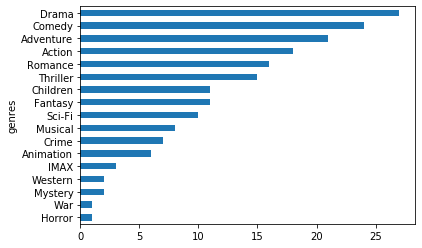

In [29]:
# now we can see what user 5 watches
show_genres_histogram_for_user(5)

### Truncate the data

To speed things up, we will work with a *truncated* version of the data, containing up to 10000 users and 1000 movies. 

**Important:** To see results with the full dataset, set `DEBUG = False`, and **rerun all cells starting from the top**. But be careful this may take a long time.

In [30]:
DEBUG = True
if DEBUG: 
    ratings_raw = ratings_raw[ (ratings_raw['userId'] < 10000) & (ratings_raw['movieId'] < 1000) ]

### Preprocess the data
Make sure that movies and users have consecutive indexes starting from 0. Also drop the timestamp column.

The resulting "cleaned" data are stored in `ratings`.

In [31]:
movieIds = ratings_raw.movieId.unique()
movieIds.sort()
userIds = ratings_raw.userId.unique()
userIds.sort()

m = userIds.size
n = movieIds.size
numRatings = len(ratings_raw)

print ("There are", m, "users,", n, "items and", numRatings, "ratings.")


## movies and users should have consecutive indexes starting from 0
# dictionaries to convert move id to consecutive index and vice versa
movieId_to_movieIDX = dict(zip(movieIds, range(0, movieIds.size)))
movieIDX_to_movieId = dict(zip(range(0, movieIds.size), movieIds))

# dictionaries to convert user id to consecutive index and vice versa
userId_to_userIDX = dict(zip(userIds, range(0, userIds.size )))
userIDX_to_userId = dict(zip(range(0, userIds.size), userIds))

## drop timestamps
ratings = pd.concat([ratings_raw['userId'].map(userId_to_userIDX),
                     ratings_raw['movieId'].map(movieId_to_movieIDX),
                     ratings_raw['rating']], axis=1)
ratings.columns = ['user', 'item', 'rating']

display(ratings.head(20))

There are 9924 users, 968 items and 394638 ratings.


,user,item,rating
0,0,1,3.5
1,0,28,3.5
2,0,31,3.5
3,0,46,3.5
4,0,49,3.5
5,0,110,3.5
6,0,148,4.0
7,0,219,4.0
8,0,249,4.0
9,0,256,4.0


In [32]:
# example
movieIDX_to_movieId[0]

1

### Create the Ratings Matrix

We will convert the `ratings` `DataFrame` into a **Ratings Matrix**. Because it is very sparse, we will use the `scipy.sparse` module to efficiently store and access it.

Specifically, we will create two versions of the same ratings matrix:
- `R` is our basic matrix and is optimized for dot products, which will be useful when computing user-user similarities; `R` is stored in the Compressed Sparse Row format (`csr_matrix`).
- `R_dok` is a different view of the ratings matrix, which allows to quickly test whether a user-item rating exists; `R_dok` is stored in the Dictionary Of Keys format (`dok_matrix`) so you can access the data like a dictionary (which is fast).

In [33]:
R = sp.csr_matrix((ratings.rating, (ratings.user, ratings.item))) # input is (data value, (index 0, index 1))
R_dok = R.todok()
# a simple test: user 0 item 534 should have a rating of 4
print("R[0, 534] value is ", R[0, 534])
print("R_dok[(0, 534)] value is ", R_dok[(0,534)])


R[0, 534] value is  4.0
R_dok[(0, 534)] value is  4.0


In [34]:
m = R.shape[0]
n = R.shape[1]
numRatings = R.count_nonzero()

print("There are m =", m, "users, n =", n, "items and", numRatings, "ratings.")

There are m = 9924 users, n = 968 items and 394638 ratings.


## The fun starts here!

### User Average Ratings

The following code computes the average rating of each user. This will be used for mean-centering, i.e., when computing similarities, as well as for making predictions.

In [35]:
user_sums = R.sum(axis=1).A1 ## matrix converted to 1-D array via .A1
user_cnts = np.diff(R.indptr) ## equivalent to, but faster than: user_cnts = (R != 0).sum(axis=1).A1
user_avgs = user_sums / user_cnts
print("user_avgs", user_avgs)

user_avgs [3.6667 4.2857 4.0588 ... 3.3441 3.2368 4.2333]


[This thread](https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr) in stack overflow, explains the method `indptr` for a sparse matrix in scipy clearly. Recommended to read for those who are inerested or got confused with the above code.

In what follows we will have 4 exercises for you. Just follow these exercises and try to fill in the missing parts of the code. after each part we have some examples with answers, so that you can sanity-check the functions that you have completed. This parts are marked by **DEBUG**. 

In the end you will have your own recommendar system, built from scratch. Have fun :)

### Exercise1: compute User-User Similarity 

The following function computes the mean-centered cosine similarity between two users.

*Tricks* that might be useful:

To subtract a scalar value `y` from all nonzero entries of a sparse vector `x`, do:
```
x.data = x.data - y
```

The dot product of a sparse vector `x` to sparse vector `y` is:
```
x.dot(y.T)
```

The norm of a sparse vector `x` is:
```
norm(x)
```


If a sparse vector `x` has only a single item, you can access it by:
```
x.A.item()
```

Note that `x.A` returns the dense representation of sparse vector `x`.

In [52]:
# some tests
u = R[1,:].copy() 
v = R[2,:].copy()
print(type(u.data))
print(u.dot(v.T))
print(u.dot(v.T).A)
print(u.dot(v.T).A.item())


<class 'numpy.ndarray'>
  (0, 0)	120.0
[[120.]]
120.0


In [53]:
def compute_pairwise_user_similarity(u_id, v_id):
    """Computes the cosine similarity between two user ids.
    dot(A,B)/norm(A)*norm(B)
    """
    u = R[u_id,:].copy()
    v = R[v_id,:].copy()
    
    ########## START HERE ##########
    ### compute the numerator and denominator
    # first compute the numerator i.e. dot product of the mean centered arrays
    u.data = u.data - user_avgs[u_id]
    # TO DO
    v.data = 
    
    numerator =  ## dot product for sparse representations
    
    denominator = # norm(u) * norm(v)
    
    ##########  END HERE  ##########
    
    if denominator == 0:
        similarity = 0.;
    else:
        similarity = numerator/denominator
    
    return similarity

**DEBUG:** For the truncated dataset, the following should output ~ `0.03585`.

In [54]:
if DEBUG:
    sim = compute_pairwise_user_similarity(2, 6)
    print(sim)

0.035854994610888584


### Exercise 2: User to all Users Similarities 

The following function computes the mean-centered cosine similarities of a given user to all other users.

You should use the `compute_pairwise_user_similarity` function defined above.


You will get a **bonus point**, if you can avoid the for loop and **NOT** invoke `compute_pairwise_user_similarity`. The idea is to obtain a copy, say `R_copy`, of matrix `R` that has its rows mean-centered and normalized. This way the given user can be represented by a mean-centered and normalized vector `u`. Then, to obtain the similarity of the user to all others, one needs to take the dot product `R_copy.dot(u.T)`. 

In [55]:
def compute_user_similarities(u_id):
    uU = np.empty((m,)) # we have m users

    ########## START HERE ##########
    ### you may use a for loop for this function
    # TO DO
    for v_id in range(m):
        sim = # pairwise similarity u_id and v_id
        uU[v_id] = sim
    ##########  END HERE  ##########
    
    return uU

def compute_user_similarities_fast(u_id):
    uU = np.empty((m,))
    
    global user_avgs, user_cnts # we already derived these two vectors
    
    ########## START BONUS ##########
    R_copy = R.copy() ## create a copy to work with
    # TO DO: repeat each user_avg, user_cnt times
    user_avgs_repeated = np.repeat()

    R_copy.data -= user_avgs_repeated ## R_copy is now mean centered
    
    ## normalize rows to unit norm
    # TO DO
    R_copy = pp.normalize() ## normalize each row: elements divided by the row norm
    u = R_copy[u_id, :]

    uU = R_copy.dot(u.T).A.flatten() ## dot product; convert to dense matrix, then flatten
    ##########  END BONUS  ##########
    return uU

**DEBUG:** For the truncated dataset, the following should again output ~ `0.03585`.

In [56]:
import time
if DEBUG:
    start = time.time()
    uU = compute_user_similarities(2)
    print("Time=", (time.time()-start))
    
    start = time.time()
    uU = compute_user_similarities_fast(2)
    print("Time=", (time.time()-start))
    
    print(uU[6])

Time= 12.554702997207642
Time= 0.013548612594604492
0.0358549946108886


In [67]:
print(uU.shape); print(uU) ## uU stores the similarity of that user to all the other users.

(9924,)
[ 0.1318  0.1268  1.     ...  0.0994  0.0856 -0.0639]


In [72]:
np.argsort(uU)[-2] # most similar user to user with user index 2

1871

Now let's compare the top 10 rated movies by user index 2 and user index 1871 which is the most similar user to user index 2.

In [76]:
show_movies_for_user(userIDX_to_userId[2])

User  3  watched  34  movies


/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


In [77]:
show_movies_for_user(userIDX_to_userId[1871])

User  1883  watched  14  movies


/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


### Exercise 3: Create User Neighborhood 

The following function creates the user neighborhood of a given user. It takes as input, the target user `u_id` and the target item`i_id`, and uses additional parameters, the size `k` of the neighborhood, and a flag `with_abs_sim`.

If `with_abs_sim` is `True`, the neighborhood should contain up to `k` users with the highest absolute similarity to the target user `u_id`.

If `with_abs_sim` is `False`, the neighborhood should contain up to `k` users with the highest similarity to the target user `u_id`.

The output of the function is `nh`, a `Dictionary` containing key-value entries of the form `v_id : sim(u_id, v_id)`, where `v_id` is another user and `sim(u_id, v_id)` is the similarity between `u_id` and `v_id`.

**Note:** The neighborhood of the target user should not contain itself, i.e., `u_id`, and only include users that have rated the target item `i_id`.


*Tricks* that might be useful:

`np.absolute(x)` returns an array containing the absolute values of each element in array `x`.

`np.argsort(x)` returns an array with the indices that sort array `x` in *increasing* order.

`x[::-1]` returns the reversed array of `x`. So, `np.argsort(x)[::-1]` contains the indices that sort x in *decreasing* order.

To check if user `u_id` has rated item `i_id`, the `R_dok` view of the ratings matrix is helpful:
```
(u_id, i_id) in R_dok
```

In [78]:

def create_user_neighborhood(u_id, i_id, k=5, with_abs_sim = False):
    """ Neighborhood for user "u_id" that have also watched item "i_id"
    """
    nh = {} ## the neighborhood dict with (user id: similarity) entries
    ## nh should not contain u_id and only include users that have rated i_id; there should be at most k neighbors
    
    uU = compute_user_similarities(u_id)
    uU_copy = uU.copy() ## so that we can modify it, but also keep the original
    
    ########## START HERE ##########
    
    if with_abs_sim:
        uU_copy = np.absolute(uU_copy)  # we only care about the absolute value of the similarity
    
    # TO DO: derive the user_ids sorted by decreasing similarity (or absolute similarity) to u_id
    user_ids =  
    
    count = 0
    for v_id in user_ids:
        if v_id == u_id: ## ignore self
            continue # go to the next iterate of the loop 
        # TO DO: replace the 'condition' such that it ignores users that have not rated i_id
        if condition: 
            continue
        nh[v_id] = uU[v_id]
        count += 1
        if count == k:
            break
    
    ##########  END HERE  ##########
    
    return nh

**DEBUG:** For the truncated dataset, the following should output sth like:
```
{550: 0.2971362420132689, 7231: 0.2740097242608031, 128: 0.26790790730529773, 6929: 0.25874452246587126, 3590: 0.251786413056871}
```

In [79]:
if DEBUG:
    print(get_name_for_movie_id(movie_id=movieIDX_to_movieId[0]))
    nh = create_user_neighborhood(u_id=userId_to_userIDX[6], i_id=0)
    print(nh)

/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


Toy Story (1995)
{2277: 0.5055001013308688, 7488: 0.4110518505839984, 9076: 0.4069446168341043, 6925: 0.39736879002769154, 4473: 0.3824178087706099}


Now we have seen what are the most similar users to user 6 that have also watched `Toy Story`

User  6  watched  23  movies


/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


User  6  watched  23  movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
6,7,Sabrina (1995),Comedy|Romance
16,17,Sense and Sensibility (1995),Drama|Romance
51,52,Mighty Aphrodite (1995),Comedy|Drama|Romance
...,...,...,...
730,743,Spy Hard (1996),Comedy
749,762,Striptease (1996),Comedy|Crime
767,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
775,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi


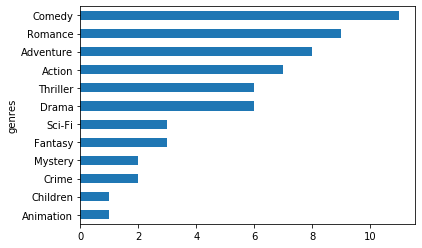

In [80]:
show_movies_for_user(6)
show_genres_histogram_for_user(6)

User  2290  watched  24  movies


/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


User  2290  watched  24  movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,5,Father of the Bride Part II (1995),Comedy
6,7,Sabrina (1995),Comedy|Romance
16,17,Sense and Sensibility (1995),Drama|Romance
61,62,Mr. Holland's Opus (1995),Drama
...,...,...,...
734,747,"Stupids, The (1996)",Comedy
767,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
789,802,Phenomenon (1996),Drama|Romance
823,838,Emma (1996),Comedy|Drama|Romance


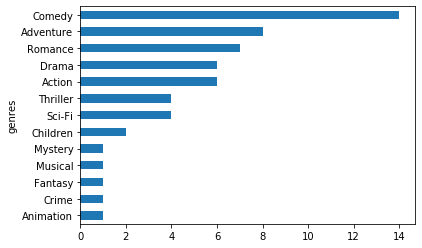

In [81]:
# Now we can see what movies the userIDX 2277 (the most similar to user_id=6) has watched.
show_movies_for_user(userIDX_to_userId[2277])
show_genres_histogram_for_user(userIDX_to_userId[2277])

### Exercise 4: Predict a Rating 

Finally! We can now try to predict a rating of a given user who has not rated an item so far. Follow the instructions bellow to see how we can do this!

The following function predicts the rating user `u_id` would give to item `i_id`. It uses the flag `with_deviations` to make the prediction.

If `with_deviations` is `True`, the prediction is made over *rating deviations*:
$$ s(u,i) = \overline{r_u} + \frac{\sum_{v \in N(u;i)}w_{uv} (r_{vi}-\overline{r_v})}{\sum_{v \in N(u;i)} |w_{uv}|} .$$

If `with_deviations` is `False`, the prediction is made directly over ratings:
$$ s(u,i) = \frac{\sum_{v \in N(u;i)}w_{uv} r_{vi}}{\sum_{v \in N(u;i)} |w_{uv}|} .$$

The output of the function is the predicted rating `prediction`.

In [86]:

def predict_rating(u_id, i_id, k, with_deviations=True, with_abs_sim=False):
    '''
    predict the rating of user u_id for item i_id 
    '''
    
    print("Movie name:", get_name_for_movie_id(movie_id=movieIDX_to_movieId[i_id]))
    
    if (u_id, i_id) in R_dok:
        print("user idx", u_id, "has rated item idx", i_id, "with", R[u_id, i_id])
    else:
        print("user idx", u_id, "has not rated item idx", i_id)
    print("k:", k, "with_deviations:", with_deviations, "with_abs_sim:", with_abs_sim)
    
    
    nh = create_user_neighborhood(u_id, i_id, k=k, with_abs_sim=with_abs_sim)
    
    neighborhood_weighted_avg = 0.

    ########## START HERE ##########
    ### you should compute neighborhood_weighted_avg, which is the fraction in the above formulas
    
    sum_scores = 0.
    sum_weights = 0.
    for neighbor_id, similarity in nh.items():
        # TO DO: find the neighbor rating from R matrix. R[neighbor_id, i_id]
        neighbor_rating = 
        if with_deviations:
            # TO DO: in this case similarity should be multiplied by (neighbor_rating - neighbor_avg)
            sum_scores += 
        else:
            sum_scores += similarity * neighbor_rating
        sum_weights += abs(similarity)
        
    neighborhood_weighted_avg = sum_scores/sum_weights
    
    ##########  END HERE  ##########
    
    if with_deviations:
        prediction = user_avgs[u_id] + neighborhood_weighted_avg
        print("prediction", prediction, "(user_avg", user_avgs[u_id], "offset", neighborhood_weighted_avg, ")")
    else:
        prediction = neighborhood_weighted_avg
        print("prediction", prediction, "(user_avg", user_avgs[u_id], ")")
        
    return prediction

**DEBUG:** For the truncated dataset, the following should output sth like:
```
Movie name: Sudden Death (1995)
user 6 has not rated item 8
k: 50 with_deviations: True with_abs_sim: True
prediction 2.7554307504988773 (user_avg 3.2830188679245285 offset -0.527588117425651 )
```

In [87]:
with_deviations = True
if DEBUG:
    k = 50
    with_deviations = True
    with_abs_sim = True
    predict_rating(6, 8, k=50, with_deviations = with_deviations, with_abs_sim=with_abs_sim)

/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


Movie name: Sudden Death (1995)
user idx 6 has not rated item idx 8
k: 50 with_deviations: True with_abs_sim: True
prediction 2.7554307504988773 (user_avg 3.2830188679245285 offset -0.527588117425651 )


In [88]:
if DEBUG:
    k = 50
    with_deviations = True
    with_abs_sim = True
    predict_rating(6, movieId_to_movieIDX[5], k=50, with_deviations = with_deviations, with_abs_sim=with_abs_sim)

/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


Movie name: Father of the Bride Part II (1995)
user idx 6 has not rated item idx 4
k: 50 with_deviations: True with_abs_sim: True
prediction 2.936704850230231 (user_avg 3.2830188679245285 offset -0.3463140176942977 )
